In [1]:
%pylab inline
rc("image", cmap="gray", interpolation="nearest")

Populating the interactive namespace from numpy and matplotlib


In [2]:
# common imports
from __future__ import print_function
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage as ndi
import sklearn
import torch
from matplotlib import gridspec
from scipy.stats import kde
from sklearn import decomposition
from torch import nn, optim
#from automlp import automlp
import automlp

import ipdb

In [3]:
import logging
reload(logging)
#logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

<module 'logging' from '/usr/lib/python2.7/logging/__init__.pyc'>

# Trainer

In [4]:
def make_model():
    return nn.Sequential(nn.Linear(28*28, 100),
                         nn.ReLU(),
                         nn.Linear(100, 10))

In [5]:
model = make_model()
trainer = automlp.Trainer(model, "crossentropy")
images = torch.randn(17, 784)
targets = (10*torch.rand(17)).to(torch.int64)
trainer.set_optimizer({})
trainer.train_batch(images, targets)

2.288259506225586

In [6]:
model = make_model()
trainer = automlp.Trainer(model, "logistic_mse")
trainer.set_optimizer({})
trainer.train_batch(images, targets)

0.2492966502904892

In [7]:
model = nn.Conv2d(3, 7, 3, padding=1)
trainer = automlp.Trainer(model, "crossentropy")
trainer.set_optimizer({})
images = torch.randn(17, 3, 28, 33)
targets = (7*torch.rand(17, 28, 33)).to(torch.int64)
trainer.train_batch(images, targets)

2.0806760787963867

In [8]:
model = nn.Conv2d(3, 7, 3, padding=1)
trainer = automlp.Trainer(model, "logistic_mse")
trainer.set_optimizer({})
images = torch.randn(17, 3, 28, 33)
targets = (7*torch.rand(17, 28, 33)).to(torch.int64)
trainer.train_batch(images, targets)

0.2658221125602722

# Datasets and RebatchingLoader

In [9]:
class TestData(torch.utils.data.Dataset):
    def __init__(self, n=1024):
        torch.utils.data.Dataset.__init__(self)
        self.n = n
    def __len__(self):
        return self.n
    def __getitem__(self, index):
        return torch.ones(784)*float(index)/self.n, index%10
    
data = TestData()

In [10]:
# testing termination conditions
loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=False)
total = 0
for batch in loader: total += len(batch[0])
print(total)
loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=False)
total2 = 0
for batch in automlp.repeated_iterator(loader, 2):
    total2 += len(batch[0])
print(total2)
assert 2*total == total2, (total, total2)

1024
2048


In [11]:
# testing termination conditions
reload(automlp)
loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=False)
total = 0
for batch in loader: total += len(batch[0])
print(total)
loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=False)
rebatched = automlp.RebatchingLoader(loader, 128, epochs=1)
total2 = 0
for batch in rebatched: total2 += len(batch[0])
assert total == total2, (total, total2)

1024


In [12]:
# testing termination conditions
loader = torch.utils.data.DataLoader(data, batch_size=256, shuffle=False)
total = 0
for batch in loader: total += len(batch[0])
loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=False)
rebatched = automlp.RebatchingLoader(loader, batch_size=128, epochs=3)
total2 = 0
for batch in rebatched: total2 += len(batch[0])
assert 3*total == total2, (total, total2)

In [13]:
# testing rebatching large -> small
reload(automlp)
loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=False)
for sample in loader: break
assert tuple(sample[0].shape) == (128, 784)
assert tuple(sample[1].shape) == (128,)
data3 = sample[0][:3]
del sample
loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=False)
rebatched = automlp.RebatchingLoader(loader, 3)
for sample in rebatched: break
assert tuple(sample[0].shape) == (3, 784)
assert tuple(sample[1].shape) == (3,)
assert (sample[0] == data3).all()

In [14]:
# testing rebatching small -> large
reload(automlp)
loader = torch.utils.data.DataLoader(data, batch_size=3, shuffle=False)
source = iter(loader)
sample = source.next()
sample = source.next()
assert tuple(sample[0].shape) == (3, 784)
assert tuple(sample[1].shape) == (3,)
data3 = sample[0][:3]
del sample
loader = torch.utils.data.DataLoader(data, batch_size=3, shuffle=False)
rebatched = automlp.RebatchingLoader(loader, 128)
for sample in rebatched: break
assert tuple(sample[0].shape) == (128, 784)
assert tuple(sample[1].shape) == (128,)
assert (sample[0][3:6] == data3).all()

In [15]:
# test length calculations
reload(automlp)
loader = torch.utils.data.DataLoader(data, batch_size=128, shuffle=False)
rebatched = automlp.RebatchingLoader(loader, batch_size=64, epochs=1)
assert 2*len(loader) == len(rebatched), (len(loader), len(rebatched))

In [16]:
# getbatch_random
inputs, targets = automlp.getbatch_random(data, 50)
inputs = torch.stack(inputs)
targets = torch.LongTensor(targets)
assert list(inputs.size()) == [50, 784], inputs.size()
assert list(targets.size()) == [50], targets.size()

In [17]:
# getbatch_batches
for sample in automlp.dataset_batches(data, 50):
    inputs, targets = sample
    break
inputs = torch.stack(inputs)
targets = torch.LongTensor(targets)
assert list(inputs.size()) == [50, 784], inputs.size()
assert list(targets.size()) == [50], targets.size()

# Full Dataset Training

In [18]:
from torchvision.datasets import mnist
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

class MnistAdapter(Dataset):
    def __init__(self, ds):
        Dataset.__init__(self)
        self.ds = ds
    def __len__(self):
        return len(self.ds)
    def __getitem__(self, index):
        inputs, targets = self.ds[index]
        return torch.FloatTensor(np.array(inputs)/255.0).reshape(-1), int(targets)

data = MnistAdapter(mnist.MNIST("./_data", download=True))
test_data = MnistAdapter(mnist.MNIST("./_data", download=True, train=False))

0.15351101048762286

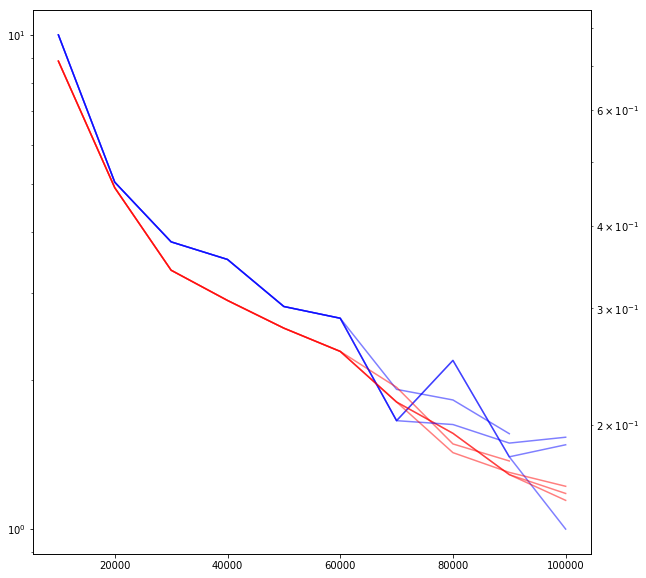

In [19]:
figsize(10, 10)
from automlp import automlp
reload(automlp)
amlp = automlp.AutoMLP(make_model, data, test_data, initial=10000, epoch=10000, maxtrain=100000)
amlp.train()
amlp.best_model.META["loss"]

0.0677

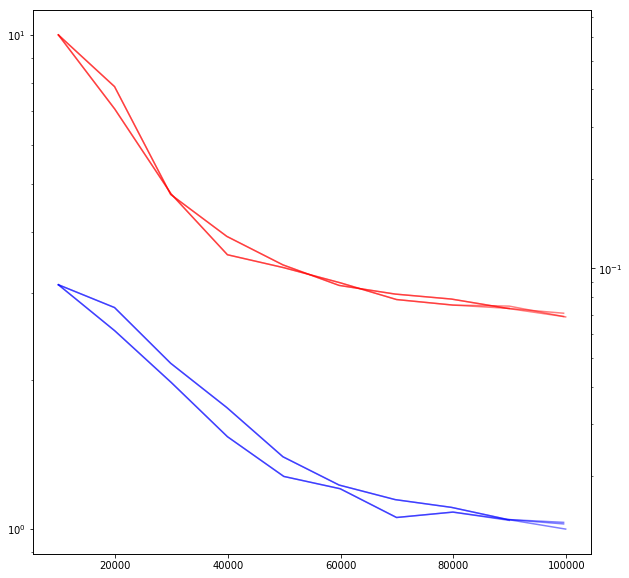

In [20]:
figsize(10, 10)
reload(automlp)
amlp = automlp.AutoMLP(make_model, data, test_data, initial=10000, epoch=10000, maxtrain=100000, mode="logistic_mse", classification=True)
amlp.train()
amlp.best_model.META["loss"]

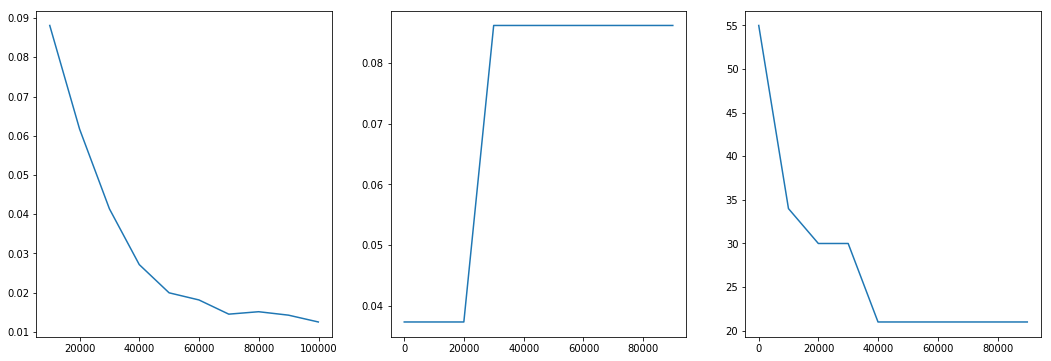

In [21]:
reload(automlp)
figsize(18,6)
subplot(131); automlp.plot_log(amlp.best_model.META["log"])
subplot(132); automlp.plot_options(amlp.best_model.META["log"])
subplot(133); automlp.plot_options(amlp.best_model.META["log"], value="batch_size")

0.0367

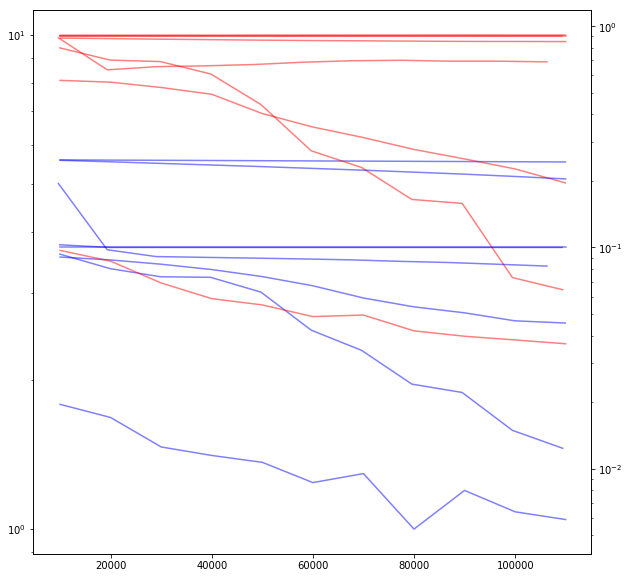

In [22]:
figsize(10, 10)
reload(automlp)
gmlp = automlp.GridSearch(make_model, data, test_data, initial=10000, epoch=10000, 
                           maxtrain=100000, mode="logistic_mse", classification=True, popsize=8)
gmlp.train()
gmlp.best_model.META["loss"]

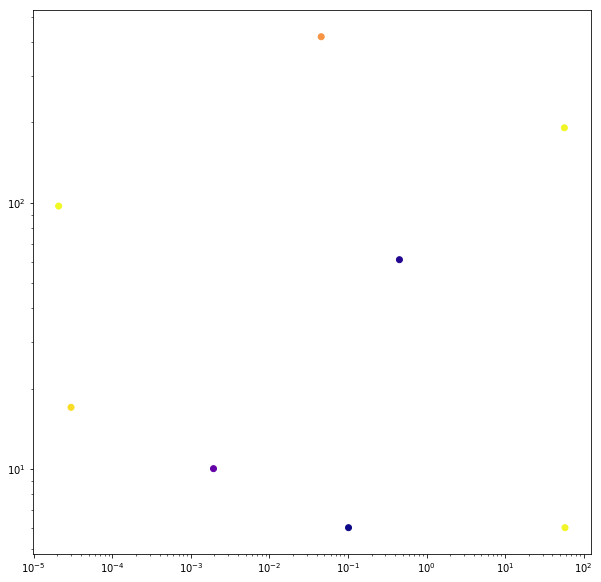

In [23]:
p = array([(m.META["params"]["lr"], m.META["params"]["batch_size"], m.META["loss"]) for m in gmlp.population])
xscale('log'); yscale('log')
scatter(p[:,0], p[:,1], c=p[:,2], cmap=cm.plasma)

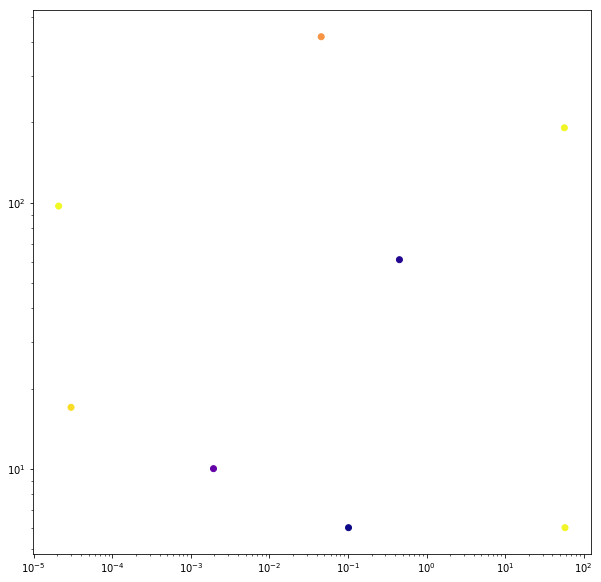

In [24]:
reload(automlp)
automlp.scatter_losses(gmlp.population)